In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
compras_df = pd.read_csv('./data/compras_enriched.csv')

In [20]:
data = compras_df.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [21]:
data.dtypes

NUM BEN             int64
BENEFICIARIO        int16
RFC                 int16
FACTURA             int16
CONTRATO            int16
CONCEPTO            int16
TIPO                 int8
# OP              float64
FECHA                int8
IMPORTE           float64
SHEET                int8
DIA                 int64
MES                 int64
YEAR                int64
BEN_SALES           int64
GASTO PROMEDIO    float64
HAS_LINKEDIN         bool
dtype: object

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [23]:
y = data.pop('IMPORTE')
X = data.copy()

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=4)

In [26]:
clf.fit(x_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [27]:
from sklearn.metrics import r2_score

In [28]:
r2_score(y_test, clf.predict(x_test))

0.18764556422060275

In [32]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [30]:
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words('spanish') and len(token)>4:
            result.append(token)
    return result

In [33]:
process_business = [preprocess(x) for x in list(compras_df['BENEFICIARIO'].unique())]

In [34]:
dictionary = gensim.corpora.Dictionary(process_business)

In [35]:
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [36]:
dictionary.filter_extremes(no_below=1, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)
for idx, type_business in lda_model.print_topics(-1):
    print('Topic:{} Words:{}'.format(idx, type_business))

Topic:0 Words:0.010*"DESARROLLOS" + 0.010*"GARZA" + 0.010*"GUERRERO" + 0.010*"INSTITUTO" + 0.010*"SALAZAR" + 0.010*"ADRIANA" + 0.010*"BANCO" + 0.010*"URBANIZACIONES" + 0.010*"IGNACIO" + 0.010*"JESUS"
Topic:1 Words:0.033*"GARCIA" + 0.021*"GONZALEZ" + 0.021*"GARZA" + 0.018*"MARIA" + 0.013*"TREVIÑO" + 0.013*"SANCHEZ" + 0.013*"MARCELO" + 0.013*"ARTURO" + 0.013*"MANUEL" + 0.009*"ALBERTO"
Topic:2 Words:0.015*"GRUPO" + 0.010*"SERVICIOS" + 0.010*"ESTHER" + 0.010*"MARTINEZ" + 0.010*"MONTERREY" + 0.010*"CONSTRUCTORA" + 0.010*"MORENO" + 0.005*"ALEJANDRO" + 0.005*"VILLARREAL" + 0.005*"HERNANDEZ"
Topic:3 Words:0.026*"MARIA" + 0.023*"RODRIGUEZ" + 0.019*"GONZALEZ" + 0.018*"GOMEZ" + 0.012*"LOZANO" + 0.008*"TORRES" + 0.008*"DESARROLLO" + 0.008*"PEREZ" + 0.008*"SEGURIDAD" + 0.008*"SANCHEZ"
Topic:4 Words:0.031*"CONSTRUCTORA" + 0.018*"CONSTRUCCIONES" + 0.018*"MEXICO," + 0.010*"NUEVO" + 0.010*"RAMIREZ" + 0.010*"SEGUROS" + 0.010*"INTEGRACION" + 0.010*"SEBASTIAN," + 0.010*"ARRENDADORA" + 0.010*"GRUPO"
Topic:

In [37]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [38]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(compras_df['BENEFICIARIO'].unique()))}
compras_df['CLUSTER_NAME'] = compras_df['BENEFICIARIO'].apply(lambda x: business_cluster[x])

<AxesSubplot:xlabel='CLUSTER_NAME'>

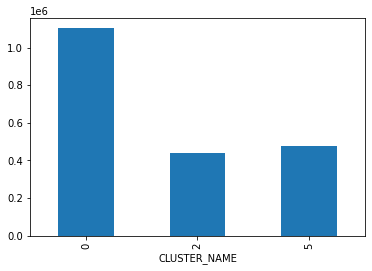

In [39]:
compras_df.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot.bar()


In [41]:
from scipy.stats import norm

In [42]:
params = norm.fit(compras_df['IMPORTE'])
params

(626317.9473441559, 4665396.47441213)

In [43]:
compras_df['PROB_TOTAL'] = [norm(params[0], params[1]).cdf(x) for x in compras_df['IMPORTE']]

In [44]:
compras_df[compras_df['PROB_TOTAL']>0.95]

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,YEAR,BEN_SALES,GASTO PROMEDIO,HAS_LINKEDIN,CLUSTER_NAME,PROB_TOTAL
283,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9.000000e+06,GASTOS VARIOS,30,12,2020,2,881659.731797,True,2,0.963661
353,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9.071256e+06,GASTOS VARIOS,11,12,2020,2,881659.731797,True,0,0.964862
354,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9.078245e+06,GASTOS VARIOS,18,12,2020,2,881659.731797,True,0,0.964978
357,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,3.000000e+07,GASTOS VARIOS,11,12,2020,1,881659.731797,False,0,1.000000
367,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,7.386437e+07,GASTOS VARIOS,17,12,2020,16,881659.731797,True,0,1.000000
368,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-B-158004-1735,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,231000103.0,2020-12-17,7.635249e+07,GASTOS VARIOS,17,12,2020,16,881659.731797,True,0,1.000000
369,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-C-158004-1733,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,240000108.0,2020-12-17,1.924614e+07,GASTOS VARIOS,17,12,2020,16,881659.731797,True,0,0.999967
370,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-A-158004-1760,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCA ...",TR,11000197.0,2020-12-28,3.610189e+07,GASTOS VARIOS,28,12,2020,16,881659.731797,True,0,1.000000
372,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-B-158004-1761,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,231000104.0,2020-12-28,3.357936e+07,GASTOS VARIOS,28,12,2020,16,881659.731797,True,0,1.000000
374,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-C-158004-1759,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,240000109.0,2020-12-28,1.336286e+07,GASTOS VARIOS,28,12,2020,16,881659.731797,True,0,0.996833


In [45]:
models_sheet={}
for sheet in list(compras_df['SHEET'].unique()):
    sheet_compras = compras_df[compras_df['SHEET'] == sheet]
    params = norm.fit(sheet_compras['IMPORTE'])
    models_sheet[sheet] = norm(params[0], params[1])


In [46]:
sheet_prob = []
for i, row in compras_df.iterrows():
    sheet_prob.append(models_sheet[row['SHEET']].cdf(row['IMPORTE']))
compras_df['PROB_SHEET'] = sheet_prob

<AxesSubplot:>

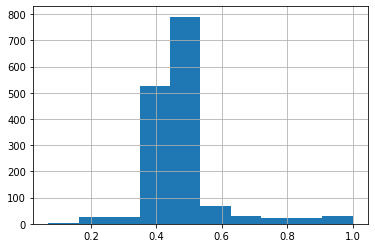

In [47]:
compras_df['PROB_SHEET'].hist()

In [48]:
compras_df[compras_df['PROB_SHEET']<0.95]

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,YEAR,BEN_SALES,GASTO PROMEDIO,HAS_LINKEDIN,CLUSTER_NAME,PROB_TOTAL,PROB_SHEET
0,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS AF8458-158008-3972,OT. 20204373,REEMPLAZO E INSTALACION DE AMORTIGUADORES (DEL...,TR,1019110.0,2020-12-11,14911.80,GASTOS VARIOS,11,12,2020,13,881659.731797,True,0,0.447867,0.428733
1,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6916-158008-4041,OT. 20204425,REEMPLAZO E INSTALACION DE OCHO BIRLOS Y NUEVE...,TR,1019110.0,2020-12-11,2528.80,GASTOS VARIOS,11,12,2020,13,881659.731797,True,0,0.446818,0.427726
2,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6917-158008-3975,OT. 20204376,REEMPLAZO DE DOS RINES (17). PATRIMONIO 80383...,TR,1019110.0,2020-12-11,8500.02,GASTOS VARIOS,11,12,2020,13,881659.731797,True,0,0.447324,0.428211
3,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7004-158008-3971,OT. 20204374,REEMPLAZO DE DOS RINES (14). PATRIMONIO 8007...,TR,1019110.0,2020-12-11,2400.01,GASTOS VARIOS,11,12,2020,13,881659.731797,True,0,0.446807,0.427715
4,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7137-158008-4554,OT. 20205130,REEMPLAZO E INSTALACION DE RIN 14. PATRIMONIO ...,TR,299001496.0,2020-12-23,1537.00,GASTOS VARIOS,23,12,2020,13,881659.731797,True,0,0.446734,0.427645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,203016,SEGOVIA PAEZ MARCELO,SEPM8603058S7,116033-158004-1689,NO APLICA,FINIQUITO 116033,CH,1104570.0,2020-12-11,183992.72,SERV. PERS.,11,12,2020,2,59623.405217,True,2,0.462233,0.927339
1536,203016,SEGOVIA PAEZ MARCELO,SEPM8603058S7,116033-158004-1690,NO APLICA,FONDO PENSIONES 116033,CH,1104571.0,2020-12-11,56430.00,SERV. PERS.,11,12,2020,2,59623.405217,True,2,0.451389,0.485086
1537,203016,TORRES ACOSTA ROBERTO CARLOS,TOAR8409234Y0,113052-158004-1725,NO APLICA,FONDO DE PENSIONES 113052,CH,299000183.0,2020-12-16,7425.00,SERV. PERS.,16,12,2020,2,59623.405217,True,5,0.447233,0.270534
1538,203016,TOVAR CEDILLO JAVIER ALFONSO,TOCJ750710A31,23016-158004-1705,NO APLICA,PAGO 30% JUICIO DE AMPARO No. 673/2020 (DICIE...,CH,299000179.0,2020-12-15,4084.68,SERV. PERS.,15,12,2020,1,59623.405217,True,5,0.446950,0.257746
